In [1]:
import sys
sys.path.extend(['../'])

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from src.data_utils import load_data
from src.metrics import strategies_comparison, icc_matrix, qc_fc

## QC-FC

In [3]:
mean_rms_vec = np.load('/home/tm/projects/BenchmarkingEOEC/notebooks/rms_beijing.npy')

In [4]:
# load data and calculate QC-FC
#datapath = '/data/Projects/OpenCloseBenchmark_data/fc_data_china'
datapath = '/home/tm/projects/BenchmarkingEOEC/fc_data_china'

closed = os.path.join(datapath, 'close')
opened = os.path.join(datapath, 'open')

nogsr, gsr = [], []
atlas = 'Brainnetome'
fc_type = ['corr', 'pc', 'glasso', 'tang']

for f in fc_type:
    # store qcfc for each strategy
    tmp_nogsr, tmp_gsr = [], []
    for strategy in range(1, 7):
        cl, op = load_data(closed, opened, 
                           fc=f, atlas=atlas, 
                           strategy=strategy, gsr='noGSR')
        
        cl_g, op_g = load_data(closed, opened, 
                               fc=f, atlas=atlas, 
                               strategy=strategy, gsr='GSR')

        tmp_nogsr.append(qc_fc(cl, mean_rms_vec).flatten())
        tmp_gsr.append(qc_fc(cl_g, mean_rms_vec).flatten())


    nogsr.append(tmp_nogsr)
    gsr.append(tmp_gsr)

/home/tm/projects/BenchmarkingEOEC/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tm/projects/BenchmarkingEOEC/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


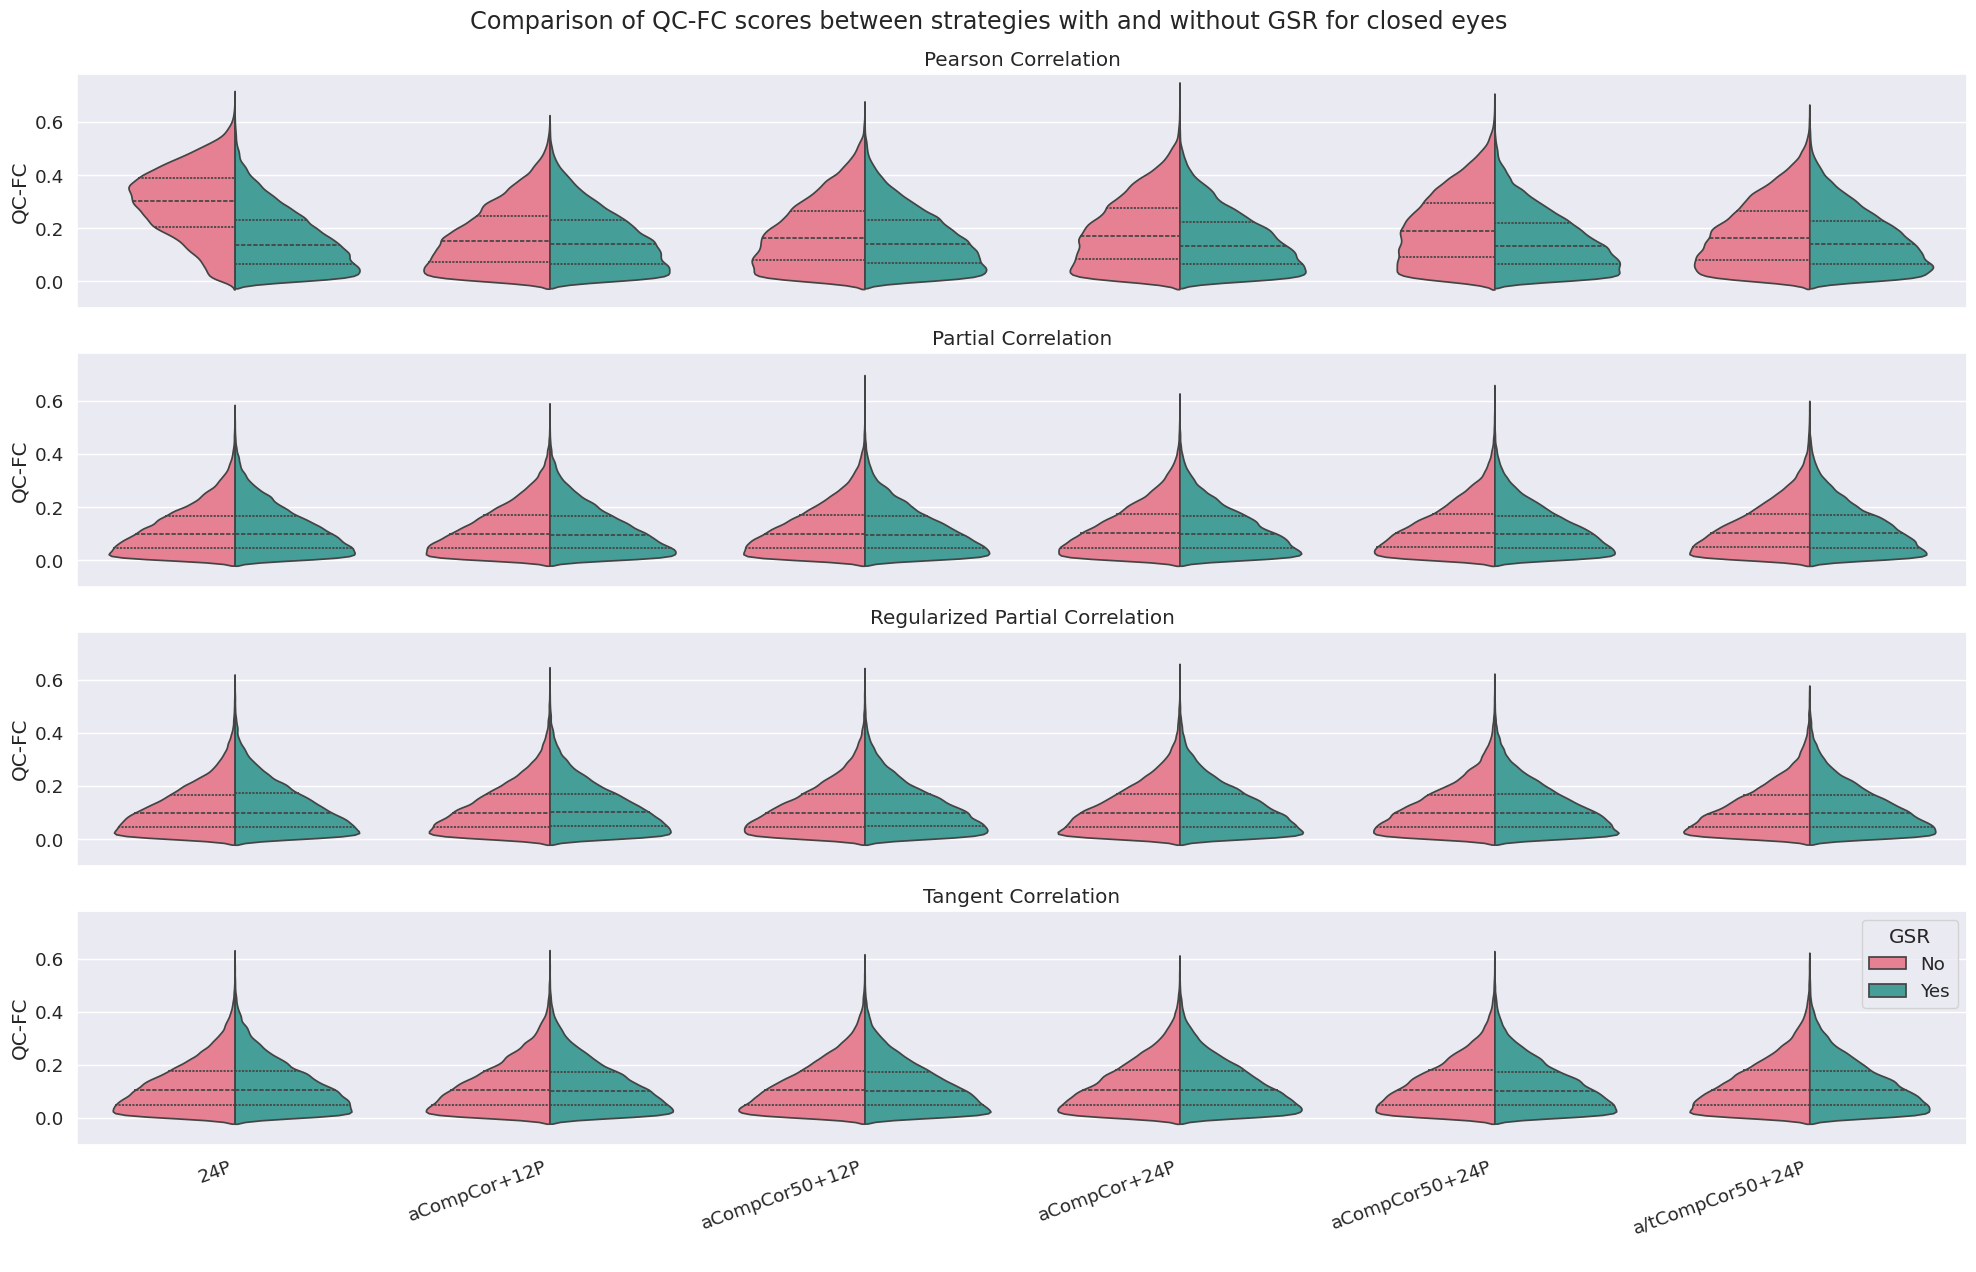

In [7]:
sns.set_theme(style='darkgrid', font='sans-serif', font_scale=1.2)

fc_name = ['Pearson Correlation', 'Partial Correlation', 'Regularized Partial Correlation', 'Tangent Correlation']
strategies =   ['24P', 
                'aCompCor+12P', 
                'aCompCor50+12P', 
                'aCompCor+24P', 
                'aCompCor50+24P', 
                'a/tCompCor50+24P',]


# create 4x1 subplots
fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(20, 13))
fig.suptitle('Comparison of QC-FC scores between strategies with and without GSR for closed eyes')

for row, ax in enumerate(axs):

    # data by FC
    data1 = np.array(nogsr[row])
    data2 = np.array(gsr[row])

    # create dataframe to effectively plot violin plot
    categories = np.repeat(strategies, data1.shape[1])
    df1 = pd.DataFrame({'Strategy': categories, 'QC-FC': data1.flatten(), 'GSR': 'No'})
    df2 = pd.DataFrame({'Strategy': categories, 'QC-FC': data2.flatten(), 'GSR': 'Yes'})
    df = pd.concat([df1, df2]).reset_index()

    if row != 3: # to create legend only for the last subplot
        sns.violinplot(x='Strategy', y='QC-FC', hue='GSR', 
                    data=df, split=True, inner='quartile', 
                    palette='husl', ax=ax, legend=False)
    else:
        sns.violinplot(x='Strategy', y='QC-FC', hue='GSR', 
                   data=df, split=True, inner='quartile', 
                   palette='husl', ax=ax)
    
    ax.set_title(fc_name[row])
    ax.set_ylim([-0.1, 0.78])

plt.xticks(rotation=20, ha='right')
plt.xlabel(' ')
plt.tight_layout()

## Similarity between strategies

In [8]:
datapath = '/home/tm/projects/BenchmarkingEOEC/fc_data_china'

closed = os.path.join(datapath, 'close')
opened = os.path.join(datapath, 'open')

df1 = strategies_comparison(closed, opened, 'tang', 'Brainnetome')

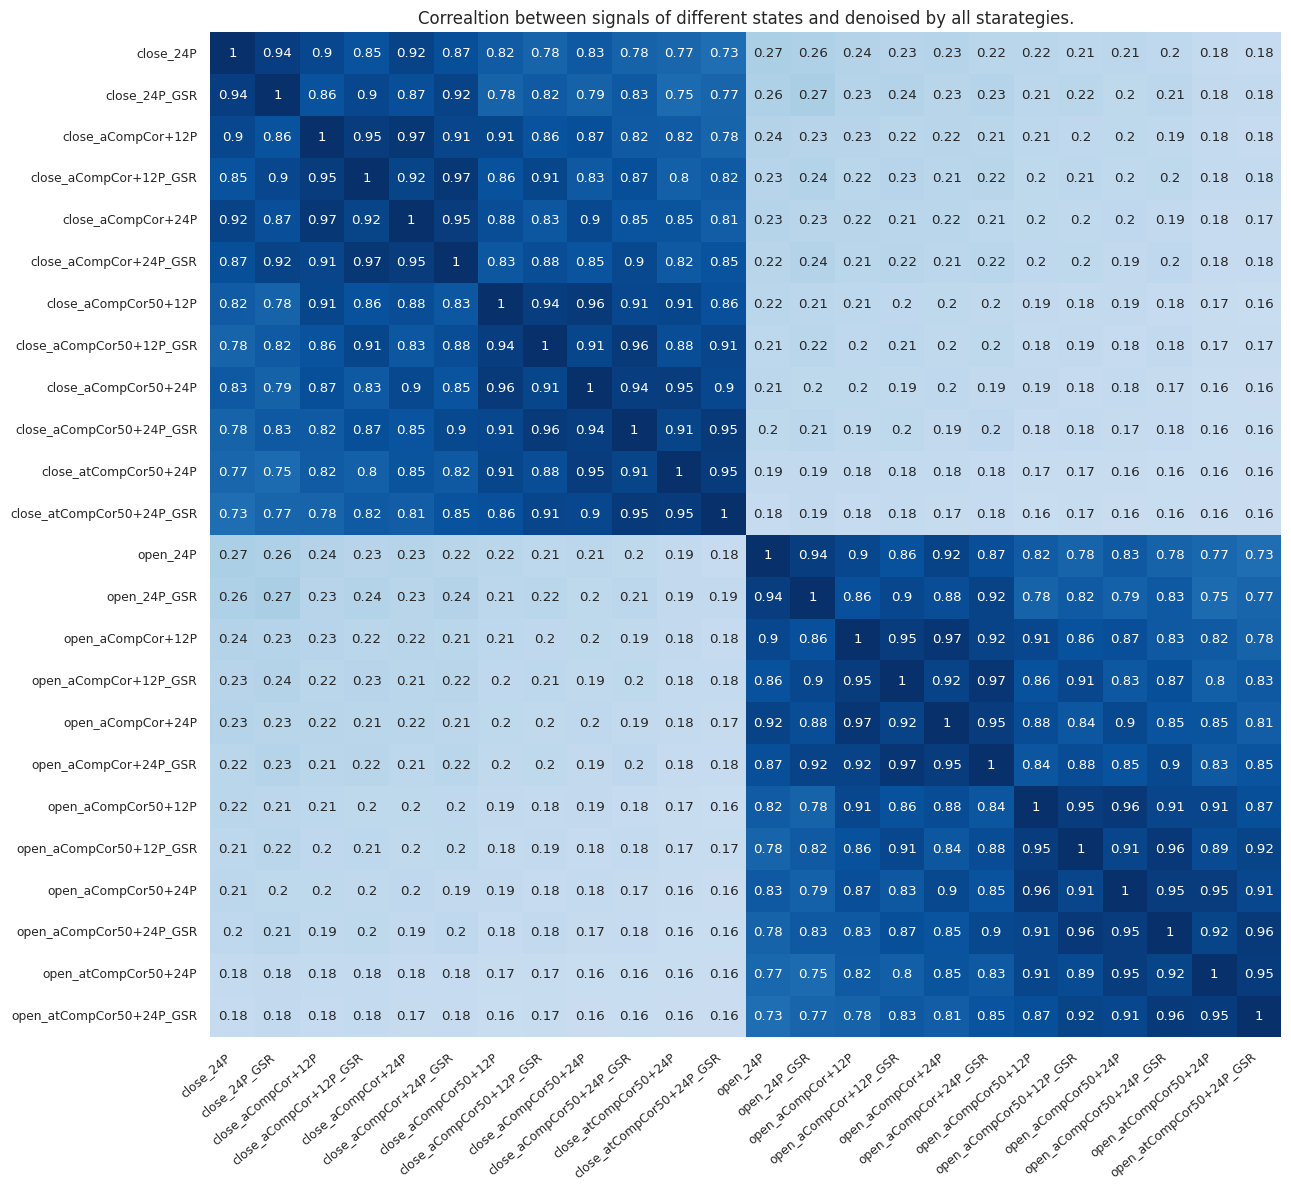

In [9]:
sns.set_theme(style='darkgrid', font='sans-serif', font_scale=0.8)

fig = plt.figure(figsize=(13, 12))
_ = sns.heatmap(df1, annot=True, cbar=False, #square=True, #cbar_kws={"shrink": 0.75},
                    vmax=1., vmin=-0.1, cmap='Blues')
plt.xticks(rotation=40, ha='right')
plt.title(f'Correaltion between signals of different states and denoised by all starategies.',
            fontdict = {'fontsize' : 12})
fig.tight_layout()

## ICC

In [15]:
datapath = '/home/tm/projects/BenchmarkingEOEC/fc_data_china'

closed = os.path.join(datapath, 'close')
opened = os.path.join(datapath, 'open')
fc = 'glasso'


masked = []
for i in range(1, 7):
    ec1, ec2 = load_data(closed, opened, fc, 'Brainnetome', i, 'noGSR', icc_session=2)
    masked.append(icc_matrix([ec1, ec2], mask=True).flatten())

    ec1, ec2 = load_data(closed, opened, fc, 'Brainnetome', i, 'GSR', icc_session=2)
    masked.append(icc_matrix([ec1, ec2], mask=True).flatten())

unmasked = []
for i in range(1, 7):
    ec1, ec2 = load_data(closed, opened, fc, 'Brainnetome', i, 'noGSR', icc_session=2)
    unmasked.append(icc_matrix([ec1, ec2], mask=False).flatten())

    ec1, ec2 = load_data(closed, opened, fc, 'Brainnetome', i, 'GSR', icc_session=2)
    unmasked.append(icc_matrix([ec1, ec2], mask=False).flatten())

data1 = np.array(masked)
data2 = np.array(unmasked)

In [ ]:
strategies =   ['24P', 
                '24P+GSR',
                'aCompCor+12P',
                'aCompCor+12P+GSR',
                'aCompCor50+12P', 
                'aCompCor50+12P+GSR', 
                'aCompCor+24P', 
                'aCompCor+24P+GSR',
                'aCompCor50+24P', 
                'aCompCor50+24P+GSR', 
                'a/tCompCor50+24P',
                'a/tCompCor50+24P+GSR']

categories = np.repeat(strategies, data1.shape[1])

df1 = pd.DataFrame({'Strategy': categories, 'ICC': data1.flatten(), 'Mask': True})
df2 = pd.DataFrame({'Strategy': categories, 'ICC': data2.flatten(), 'Mask': False})
df = pd.concat([df1, df2]).reset_index()

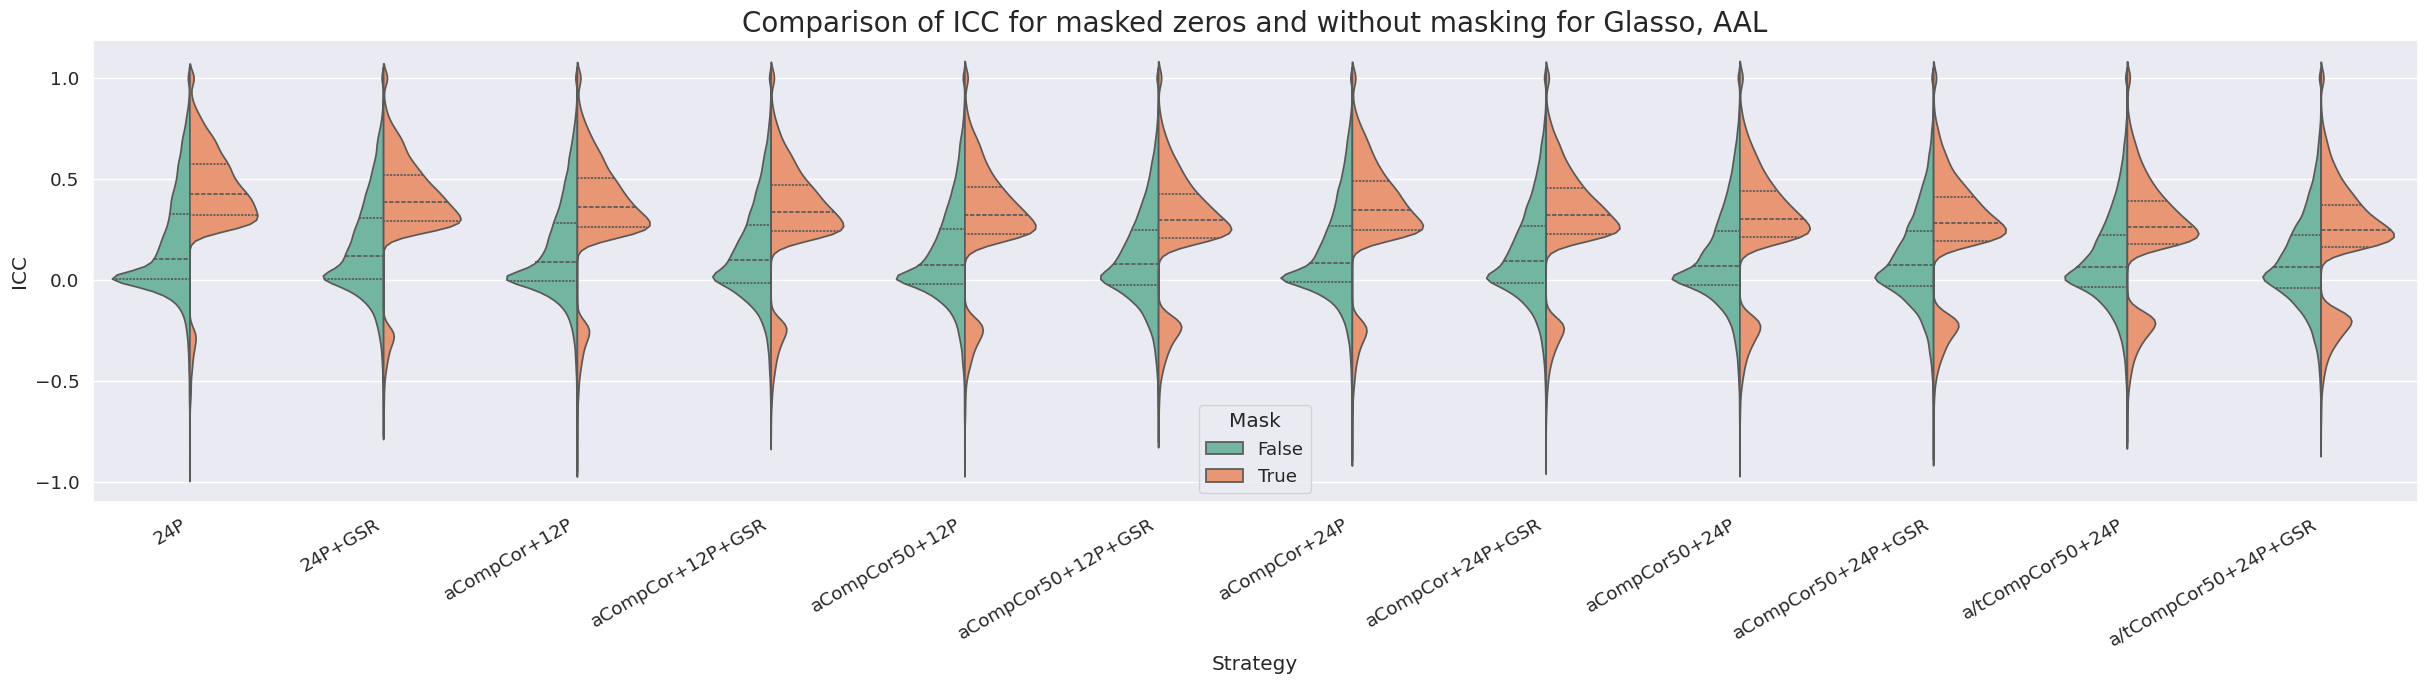

In [21]:
sns.set_theme(style='darkgrid', font='sans-serif', font_scale=1.2)

plt.figure(figsize=(30, 6))
sns.violinplot(x='Strategy', y='ICC', hue='Mask', data=df, split=True, inner='quartile', palette='Set2')

# Настройки
plt.title('Comparison of ICC for masked zeros and without masking for Glasso, AAL', fontdict={'fontsize':20})
plt.xticks(rotation=30, ha='right')

plt.show()


## Classification

In [37]:
from src.model import LogRegPCA
from sklearn.model_selection import train_test_split

In [35]:
datapath = '/home/tm/projects/BenchmarkingEOEC/fc_data_china'

closed = os.path.join(datapath, 'close')
opened = os.path.join(datapath, 'open')
fc = 'glasso'
strategy = 1
gsr = 'noGSR'
atlas = 'Brainnetome'


closed_data, open_data = load_data(closed, opened, 
                                   fc, atlas, strategy, 
                                   gsr, icc_session=None)

X = np.concatenate([closed_data, open_data], axis=0)
y = [0]*len(closed_data) + [1]*len(open_data)

In [40]:
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)
        
logreg = LogRegPCA(pca=True)

_ = logreg.model_training(x_train, y_train)
_, acc, _ = logreg.model_testing(x_test, y_test)

Accuracy on train: 1.0
Accuracy on test: 0.368
F1 score on test: 0.5
